In [ ]:
import google.generativeai as genai
from getpass import getpass
import pandas as pd
import json
from tqdm import tqdm

In [ ]:
import requests

API_URL = "https://api.perplexity.ai/chat/completions"
API_KEY = "ENTER_THE_API_KEY_HERE"  # your key

payload = {
    "model": "sonar-pro",
    "messages": [
        {"role": "user", "content": "Hi, what is the model used?"}
    ],
    "max_tokens": 1000
}

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

resp = requests.post(API_URL, headers=headers, json=payload)

if resp.status_code == 200:
    data = resp.json()
    reply = data["choices"][0]["message"]["content"]
    print("Assistant reply:", reply)
else:
    print("Error:", resp.status_code, resp.text)



Assistant reply: I’m an OpenAI-based **GPT‑5.1–class large language model**, accessed through an API and wrapped as a **text-based AI assistant** similar to systems like ChatGPT or Claude.


In [ ]:

import requests
import pandas as pd
import json
import re
from tqdm import tqdm


In [ ]:
API_KEY = "NIL"   # replace with your real key
API_URL = "https://api.perplexity.ai/chat/completions"

def call_llm(prompt):
    payload = {
        "model": "sonar-pro",
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "max_tokens": 500
    }

    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    resp = requests.post(API_URL, headers=headers, json=payload)

    if resp.status_code == 200:
        data = resp.json()
        return data["choices"][0]["message"]["content"]
    else:
        return None


In [ ]:
df = pd.read_csv('/content/yelp.csv')
df = df[['text', 'stars']]
sample_df = df.sample(200, random_state=42).reset_index(drop=True)
sample_df.head()


,text,stars
0,We got here around midnight last Friday... the...,4
1,Brought a friend from Louisiana here. She say...,5
2,"Every friday, my dad and I eat here. We order ...",3
3,"My husband and I were really, really disappoin...",1
4,Love this place! Was in phoenix 3 weeks for w...,5


In [ ]:
def prompt_zero_shot(review):
    return f"""
You are a strict JSON generator.

Predict Yelp rating (1 to 5).
Return ONLY pure JSON.

Review: "{review}"

Format:
{{
 "predicted_stars": number,
 "explanation": "short reason"
}}
"""


In [ ]:
few_shot_examples = """
Review: "Amazing service and food!"
Output: {"predicted_stars": 5, "explanation": "very positive"}

Review: "Terrible, never coming back."
Output: {"predicted_stars": 1, "explanation": "very negative"}

Review: "Average experience."
Output: {"predicted_stars": 3, "explanation": "neutral"}
"""

def prompt_few_shot(review):
    return f"""
You must output ONLY raw JSON. No markdown.

Follow examples:

{few_shot_examples}

Classify this review:
"{review}"

Return JSON:
{{
 "predicted_stars": number,
 "explanation": "short reason"
}}
"""


In [ ]:
def prompt_cot(review):
    return f"""
Think internally but DO NOT show your steps.

Return ONLY JSON.

Review: "{review}"

{{
 "predicted_stars": number,
 "explanation": "brief reason"
}}
"""


In [ ]:
def extract_json(output):
    if output is None:
        return None

    match = re.search(r"\{.*\}", output, re.DOTALL)
    if not match:
        return None

    try:
        return json.loads(match.group())
    except:
        return None


In [ ]:
def evaluate_prompt(prompt_fn):
    results = []

    for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
        review = row['text']
        gold = row['stars']

        prompt = prompt_fn(review)
        output = call_llm(prompt)
        parsed = extract_json(output)

        if parsed is None:
            results.append({"gold": gold, "pred": None, "valid_json": 0})
            continue

        pred = parsed.get("predicted_stars", None)
        results.append({"gold": gold, "pred": pred, "valid_json": 1})

    return pd.DataFrame(results)


In [ ]:
res_zero = evaluate_prompt(prompt_zero_shot)
res_few  = evaluate_prompt(prompt_few_shot)
res_cot  = evaluate_prompt(prompt_cot)


100%|██████████| 200/200 [09:40<00:00,  2.90s/it]


In [ ]:
def compute_metrics(df):
    acc = (df['gold'] == df['pred']).mean()
    json_rate = df['valid_json'].mean()
    return acc, json_rate

print("Zero-shot:", compute_metrics(res_zero))
print("Few-shot:", compute_metrics(res_few))
print("CoT:", compute_metrics(res_cot))


Zero-shot: (np.float64(0.55), np.float64(0.995))
Few-shot: (np.float64(0.55), np.float64(1.0))
CoT: (np.float64(0.625), np.float64(1.0))



=== Analysis for Zero-shot ===
Samples (valid): 199
Accuracy: 0.5628140703517588

Classification report:

              precision    recall  f1-score   support

           1      0.765     0.722     0.743        18
           2      0.500     0.529     0.514        17
           3      0.643     0.281     0.391        32
           4      0.640     0.405     0.496        79
           5      0.490     0.925     0.641        53

    accuracy                          0.563       199
   macro avg      0.608     0.572     0.557       199
weighted avg      0.600     0.563     0.542       199



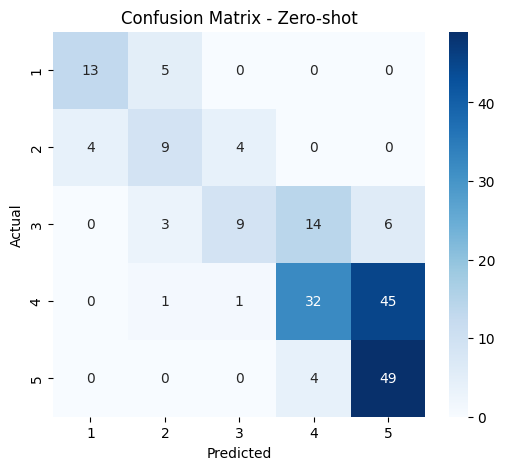

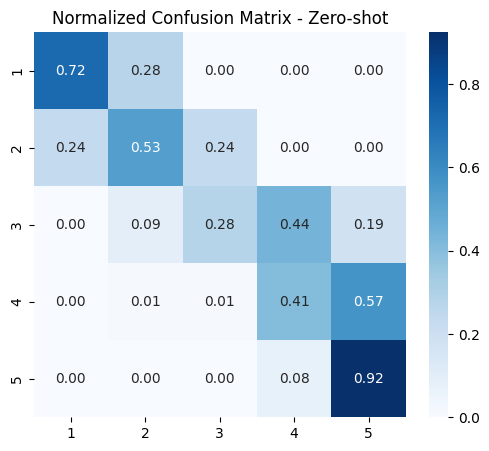


=== Analysis for Few-shot ===
Samples (valid): 200
Accuracy: 0.55

Classification report:

              precision    recall  f1-score   support

           1      0.778     0.778     0.778        18
           2      0.500     0.529     0.514        17
           3      0.667     0.303     0.417        33
           4      0.634     0.329     0.433        79
           5      0.472     0.962     0.634        53

    accuracy                          0.550       200
   macro avg      0.610     0.580     0.555       200
weighted avg      0.598     0.550     0.522       200



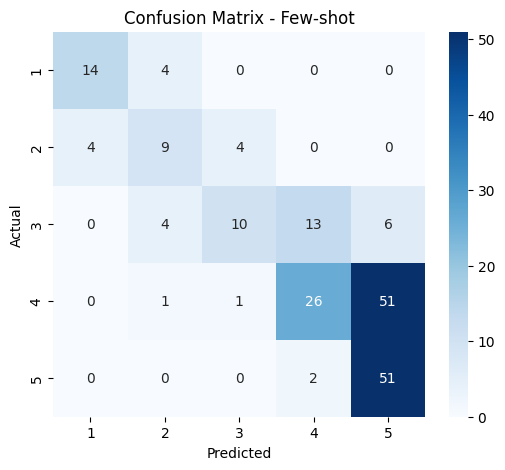

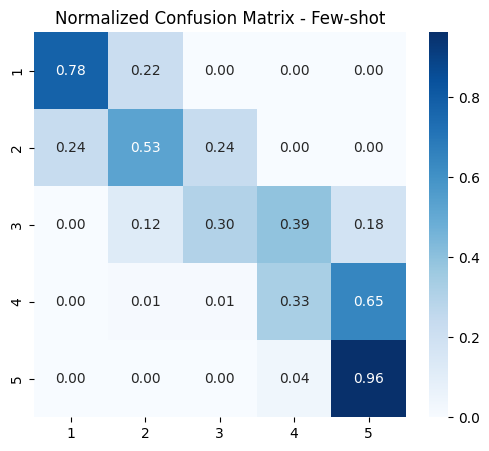


=== Analysis for CoT ===
Samples (valid): 200
Accuracy: 0.635

Classification report:

              precision    recall  f1-score   support

           1      0.875     0.778     0.824        18
           2      0.550     0.647     0.595        17
           3      0.765     0.394     0.520        33
           4      0.722     0.494     0.586        79
           5      0.538     0.943     0.685        53

    accuracy                          0.635       200
   macro avg      0.690     0.651     0.642       200
weighted avg      0.679     0.635     0.624       200



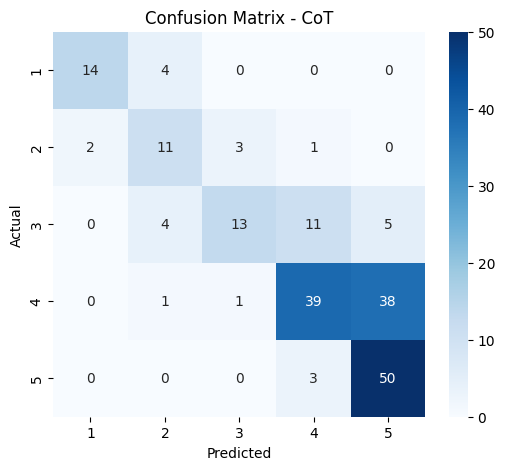

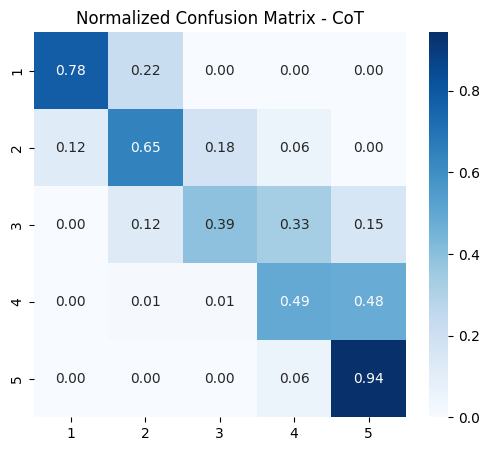

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_results(df, label):
    # drop invalid
    df_valid = df[df['pred'].notnull()].copy()
    y_true = df_valid['gold'].astype(int).values
    y_pred = df_valid['pred'].astype(int).values

    print(f"\n=== Analysis for {label} ===")
    print("Samples (valid):", len(df_valid))
    print("Accuracy:", (y_true==y_pred).mean())

    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, digits=3))

    cm = confusion_matrix(y_true, y_pred, labels=[1,2,3,4,5])
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {label}')
    plt.show()

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    plt.title(f'Normalized Confusion Matrix - {label}')
    plt.show()

# Run for each prompt
analyze_results(res_zero, "Zero-shot")
analyze_results(res_few,  "Few-shot")
analyze_results(res_cot,  "CoT")
